In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
#MLP revisited
n_embd = 10     #Dimension of charcter embedding vector
n_hidden = 200  #no. of neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn(vocab_size,                        generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 24.6599
  10000/ 200000: 2.1508
  20000/ 200000: 2.1685
  30000/ 200000: 2.0796
  40000/ 200000: 2.4378
  50000/ 200000: 2.2221
  60000/ 200000: 2.2697
  70000/ 200000: 2.7739
  80000/ 200000: 2.5975
  90000/ 200000: 2.3698
 100000/ 200000: 2.4301
 110000/ 200000: 1.8470
 120000/ 200000: 2.2064
 130000/ 200000: 1.9504
 140000/ 200000: 1.7623
 150000/ 200000: 2.4774
 160000/ 200000: 2.1412
 170000/ 200000: 1.7678
 180000/ 200000: 1.9550
 190000/ 200000: 2.1278


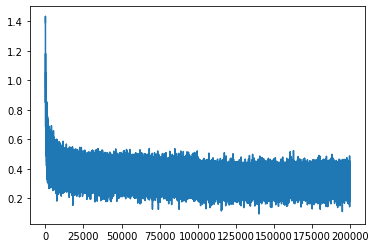

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1062216758728027
val 2.155881643295288


In [11]:
# sample
g = torch.Generator().manual_seed(2147483647 +10)

for i in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amori.
kih.
jari.
reety.
salaysleer.
hunna.
merynci.
aqui.
nellara.
chaiiv.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wanthoniearyxis.
kael.
dura.
